In [ ]:
#install.packages("openssl")
#library("openssl")
#sha256(c("james","salil","james"), key="my_secret")

In [ ]:

localRelease <- function(x, values=c(-1,1), epsilon){
	draw <- runif(n=1, min=0, max=1)
	cutoff <- 1/(1+exp(epsilon))
	if(draw<cutoff){
		return(values[!values%in%x])		
	}else{
		return(x)
	}
}

## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}


localHistogramRelease <- function(x, lower, upper, nbins=0, epsilon){
	n <- length(x)
	if(nbins==0){
		lower <- floor(lower)
		upper <- ceiling(upper)
		bins <- lower:upper   
        nbins <- length(bins)
    }

    x.clipped <- clip(x=x, lower=lower, upper=upper)

	sensitivity <- 2
	scale <- sensitivity / epsilon

	sensitiveValue <- DPrelease <- rep(NA,nbins)
	for(i in 1:length(bins)){
		sensitiveValue[i] <- sum(x.clipped==bins[i])
		DPrelease[i] <- localRelease(sensitiveValue[i], values=c(0,1), epsilon=epsilon/2)
	}

	return(list(release=DPrelease, true=sensitiveValue, codebook=bins))
}


## Sample with replacement from a vector
bootstrap <- function(x, y=NULL, n){
	index <- sample(x=1:length(x), size=n, replace=TRUE) 

	if(is.null(y)){
		return(x[index])
	}else{
		return(list(x=x[index], y=y[index]))
	}
}


correction <- function(release, epsilon){
	inflation <- (exp(epsilon) + 1)/(exp(epsilon) - 1)
	expectation <- mean(release * inflation)
	return(expectation)
}

correction01 <- function(release, epsilon, sensitivity=1){
	inflation <- (exp(epsilon/sensitivity) + 1)/(exp(epsilon/sensitivity) - 1)
	release.trans <- (release-0.5)*2
	expectation <- release.trans * inflation
	expectation.trans <- expectation/2 + 0.5
	return(expectation.trans)
}


truefrac <- function(x, lower, upper){
	fractions <- hist(x, breaks=(lower:(upper+1)-0.5), plot=FALSE)$density
	return(fractions)
}



#Side-by-side histograms for Local Releases
showHistLocal <- function(DPrelease, true, codebook, main="Histogram"){

	semi.blue <- rgb(0,90,239,150,maxColorValue=255)          # Slightly transparent colors
	semi.red  <- rgb(239,90,0,150,maxColorValue=255)

	allylim <- c(min(c(DPrelease,true), na.rm = TRUE), max(c(DPrelease, true), na.rm = TRUE))
	granularity <- (max(codebook) - min(codebook))/(length(codebook)-1)

	allxlim <- c(min(codebook) - 0.5*granularity, max(codebook + 0.5*granularity))

    # Build empty plot
	plot.new()
	plot.window( xlim=allxlim, ylim=allylim)
	title(main = main)
	axis( side=1 )
	axis( side=2 )

	tiny <- granularity*0.03 # slight spacing between bars
	overlap <- granularity*0.2 # some small overlap between sensitive and DP values

	for(i in 1:length(codebook)){
		rect(xleft=codebook[i]-overlap, ybottom=0, xright=codebook[i]+0.5*granularity-tiny, ytop=true[i], col=semi.red)
		rect(xleft=codebook[i]-0.5*granularity+tiny, ybottom=0, xright=codebook[i]+overlap, ytop=DPrelease[i], col=semi.blue)
	}
}

In [ ]:
# use first letter of string
thash <- function(x){
	x <- tolower(x)
	hash<-NULL
	for(i in 1:length(x)){
		first.letter <- substr(x[i], start=1, stop=1)
		temp <- which(first.letter==letters)      
		hash <- c(hash, max(temp,0))         # max helps map nonletters to 0
	}
	return(hash)
}

# use last letter of string
thash2 <- function(x){
	x <- tolower(x)
	hash<-NULL
	for(i in 1:length(x)){
		last.letter <- substr(x[i], start=nchar(x[i]), stop=nchar(x[i]))
		temp <- which(last.letter==letters)      
		hash <- c(hash, max(temp,0))         # max helps map nonletters to 0
	}
	return(hash)
}

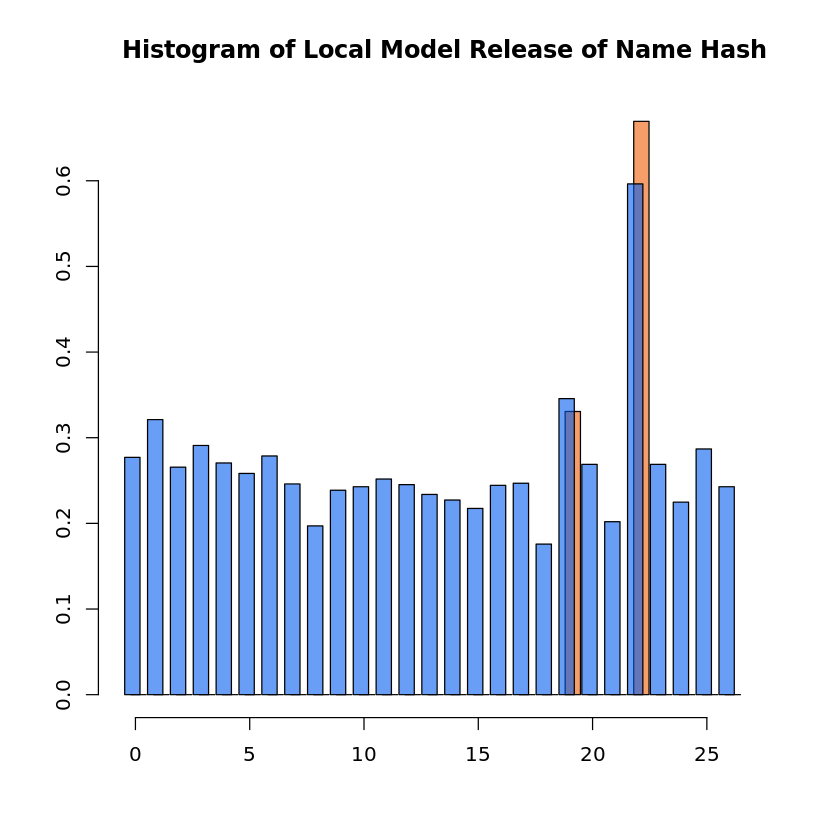

In [ ]:
data("iris")




names <- bootstrap(iris$Species, n=5000) 

out2 <- out3 <- matrix(NA, nrow=length(names), ncol=27)

names.hash <- thash(names)
for(i in 1:length(names.hash)){
	out2[i,] <- localHistogramRelease(x=names.hash[i], lower=0, upper=26, epsilon=0.5)$release
}

names.hash2 <- thash2(names)
for(i in 1:length(names.hash)){
	out3[i,] <- localHistogramRelease(x=names.hash2[i], lower=0, upper=26, epsilon=0.5)$release
}

values <- apply(out2,2,mean)
DPmeans <- correction01(values, epsilon=0.5)
true <- truefrac(names.hash, lower=0, upper=26)

showHistLocal(DPrelease=DPmeans, true=true, codebook=0:27, main="Histogram of Local Model Release of Name Hash")

In [ ]:
clientSFP <- function(x, epsilon, myhash){
	a <- localHistogramRelease(x=myhash(x), lower=0, upper=26, epsilon=epsilon)$release # Correct this
	l <- sample(1:10,1)
	b <- substr(x,start=l,stop=l)
	return(list(a=a, b=b, l=l))
}

x<- bootstrap(iris$Species, n=10000)
l <- rep(1,length(x))
b <- rep("a",length(x))
out4 <- matrix(NA, nrow=length(x), ncol=27)
myepsilon <- 2


for(i in 1:length(x)){
	release <- clientSFP(x[i], epsilon=myepsilon, myhash=thash)
	out4[i,] <- release$a
	b[i] <- release$b
	l[i] <- release$l
}

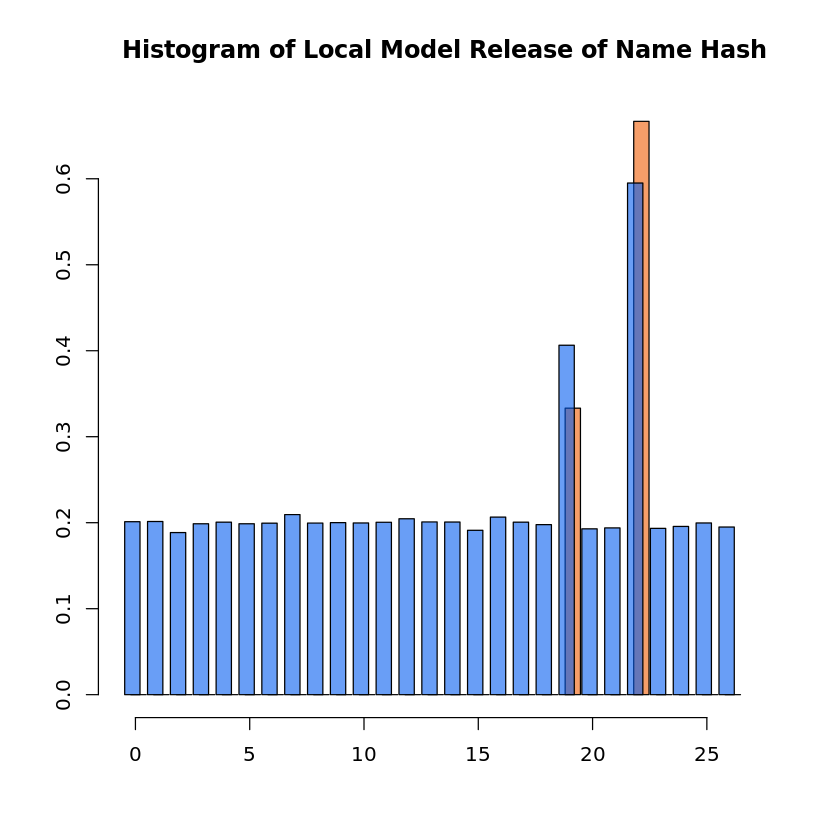

In [ ]:
# Show identified hash

codebook<- 0:26
values <- apply(out4,2,mean)
DPmeans <- correction01(values, epsilon=myepsilon)
true <- truefrac(thash(x), lower=0, upper=26)

showHistLocal(DPrelease=DPmeans, true=true, codebook=0:27, main="Histogram of Local Model Release of Name Hash")

In [ ]:
# Piece together puzzle

Threshold <- 0.3
discovered <- which(DPmeans>Threshold) 

cat("Actual Names: \n")
cat(paste(sort(unique(iris$Species)), "\n"))

for(j in 1:length(discovered)){
	flag <- out4[,discovered[j]] == 1
	temp.b <- b[flag]
	temp.l <- l[flag]
	t <- table(temp.b,temp.l)
	print(t)
	size <- ncol(t)
	word <- rep("",size)
	for(k in 1:ncol(t)){
		word[k]<-row.names(t)[which(t[,k]==max(t[,k]))][1]
	}
	print(word)
}

Actual Names: 
setosa 
 versicolor 
 virginica 
      temp.l
temp.b   1   2   3   4   5   6   7   8   9  10
         0   0   0   0   0   0 238 258 240 326
     a   0   0   0   0   0 226   0   0  96   0
     c   0   0   0   0   0  96   0  77   0   0
     e   0 338   0   0   0   0   0   0   0   0
     g   0   0   0  96   0   0   0   0   0   0
     i   0  95   0   0 171   0  99   0   0   0
     l   0   0   0   0   0   0   0 111   0   0
     n   0   0   0   0   0  90   0   0   0   0
     o   0   0   0 249   0   0 113   0  93   0
     r   0   0 182   0   0   0   0   0   0  92
     s 246   0   0  95 246   0   0   0   0   0
     t   0   0 242   0   0   0   0   0   0   0
     v 172   0   0   0   0   0   0   0   0   0
 [1] "s" "e" "t" "o" "s" "a" ""  ""  ""  "" 
      temp.l
temp.b   1   2   3   4   5   6   7   8   9  10
         0   0   0   0   0   0  82 106  85 314
     a   0   0   0   0   0  70   0   0 236   0
     c   0   0   0   0   0 260   0 231   0   0
     e   0 294   0   0   0   0   0 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0df97151-1c38-49bc-a037-2a058b96fd82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>